# Lesson 6 - Starter code for guided practice & demos

In [1]:
# Imports
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn import cross_validation, linear_model, metrics
%matplotlib inline

# Config
sns.set_style("darkgrid")
DATA_DIR = Path('./resources/')
np.random.seed(1)

## Slide: "Let's compare two random models"

   x  y
0  0  0
1  1  1
2  2  2
3  3  3
4  4  4

   x  y
0  1  1
1  1  1
2  1  1
3  1  1
4  1  1


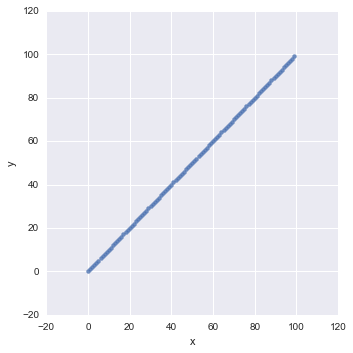

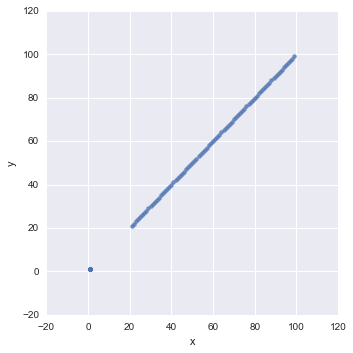

In [2]:
# Create two dfs of data
df = pd.DataFrame({'x': range(100), 'y': range(100)})
biased_df = df.copy()
biased_df.loc[:20, 'x'] = 1
biased_df.loc[:20, 'y'] = 1

# What do these look like?
print df.head()
print
print biased_df.head()
print sns.lmplot('x', 'y', df, fit_reg=False)
print sns.lmplot('x', 'y', biased_df, fit_reg=False)

          x          y
0  4.170220   3.266449
1  8.203245   6.270581
2  2.001144  10.859421
3  6.023326   6.572698
4  5.467559  13.085352

           x         y
0  10.501761  9.118587
1   6.566532  9.749616
2  10.156063  7.884133
3   7.415662  6.694944
4   4.900077  2.609714


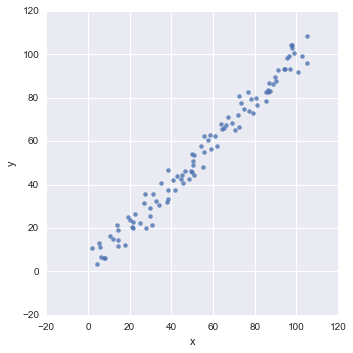

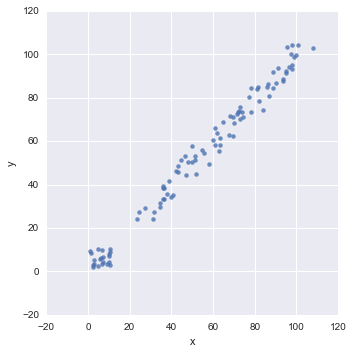

In [3]:
# Now "jitter" them by adding some random variates
def append_jitter(series):
    jitter = 10 * np.random.random_sample(size=100)
    return series + jitter

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)

print df.head()
print
print biased_df.head()
print sns.lmplot('x', 'y', df, fit_reg=False)
print sns.lmplot('x', 'y', biased_df, fit_reg=False)

In [4]:
## Fit a LinearRegression to each
lm = linear_model.LinearRegression().fit(df[['x']], df['y'])
biased_lm = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])

In [5]:
# Evaluate MSE for unbiased model (trained on unbiased data) against the unbiased data
print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))

# Evaluate the MSE for biased model (trained on biased data) against the BIASED data
print metrics.mean_squared_error(biased_df['y'], biased_lm.predict(biased_df[['x']]))

# Evaluate the MSE for biased model (trained on biased data) against the UNBIASED data
print metrics.mean_squared_error(df['y'], biased_lm.predict(df[['x']]))

# If model (or dataset on which it was trained) has a lot of bias, it may have low MSE
# or good R^2 on its own dataset, but won't generalise as well to new data. We'd therefore
# like to find a way to prevent against this bias (this will unfortunately increase variance,
# i.e. R^2 will decrease & MSE will increase for the unbiased model vs unbiased data).

18.5449061202
16.6440233816
19.027066123


## Slide: "Using k-fold cross-validation with MSE"

In [6]:
# Read in bikeshare data
bikeshare = pd.read_csv(DATA_DIR / 'bikeshare.csv')
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [7]:
# Dummy the weather categories & create new modelling dataset + output vector from 'casual' column
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual

In [21]:
# Create k-fold cross-validation (kf contains indices for selecting train/test sets)
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)
print kf
list(kf)

sklearn.cross_validation.KFold(n=17379, n_folds=5, shuffle=True, random_state=None)


[(array([    0,     1,     2, ..., 17375, 17377, 17378]),
  array([    3,     4,    14, ..., 17358, 17367, 17376])),
 (array([    0,     3,     4, ..., 17374, 17375, 17376]),
  array([    1,     2,     5, ..., 17373, 17377, 17378])),
 (array([    1,     2,     3, ..., 17376, 17377, 17378]),
  array([    0,     8,     9, ..., 17368, 17370, 17372])),
 (array([    0,     1,     2, ..., 17376, 17377, 17378]),
  array([    6,    15,    16, ..., 17355, 17359, 17371])),
 (array([    0,     1,     2, ..., 17376, 17377, 17378]),
  array([   23,    24,    27, ..., 17369, 17374, 17375]))]

In [22]:
# Build models on subsets of the data
scores = []
for train_index, test_index in kf:
    train_X = modeldata.iloc[train_index]
    train_y = y.iloc[train_index]
    test_X = modeldata.iloc[test_index]
    test_y = y.iloc[test_index]
    lm = linear_model.LinearRegression().fit(train_X, train_y)
    test_predictions = lm.predict(test_X)
    scores.append(metrics.mean_squared_error(test_y, test_predictions))
    
print scores
print np.mean(scores)

[1428.3298613460956, 1750.0187127587446, 1781.2456291671456, 1757.7594436497402, 1651.1501572717239]
1673.70076084


In [18]:
# This score will be lower (i.e. better), we're reducing variance by improving bias (using all the data)
lm = linear_model.LinearRegression().fit(modeldata, y)
print "MSE for simple linear regression:", metrics.mean_squared_error(y, lm.predict(modeldata))

# Which approach do you think would predict more accurately for new data?

MSE for simple linear regression: 1672.58110765


## Activity: Cross-validation for linear regression

If we were to continue increasing the number of folds in cross-validation, would error increase or decrease?

Directions:
1. Using the above code example, perform k-fold cross validation for all even numbers between 2 and 50. (Hint:  range(2, 51, 2) produces a list of even numbers from 2 to 50)
2. Answer the following questions:
  - What does `shuffle=True` do?
  - At what point does cross validation no longer seem to help the model?

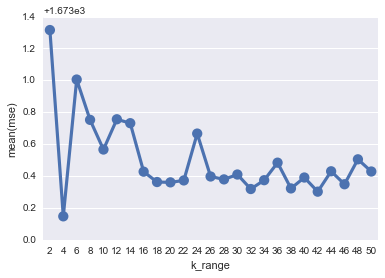

In [64]:
# code here
results = []
for i in range(2,51,2):
    kf = cross_validation.KFold(len(modeldata), n_folds=i, shuffle=True)
    scores = []
    for train_index, test_index in kf:
        train_X = modeldata.iloc[train_index]
        train_y = y.iloc[train_index]
        test_X = modeldata.iloc[test_index]
        test_y = y.iloc[test_index]
        lm = linear_model.LinearRegression().fit(train_X, train_y)
        test_predictions = lm.predict(test_X)
        scores.append(metrics.mean_squared_error(test_y, test_predictions))
    results.append(np.mean(scores))
sns.pointplot(x="k_range", y="mse", data=pd.DataFrame({'k_range': range(2,51,2), 'mse': results}))

Shuffle = True takes random slices from the index; False takes the slices in order.

## Slide: "Where regularisation makes sense"

In [ ]:
# Evaluate MSE for whole model using LinearRegression (no regularisation), then regularised regression
lm = linear_model.LinearRegression().fit(modeldata, y)
lasso_lm = linear_model.Lasso().fit(modeldata, y)
ridge_lm = linear_model.Ridge().fit(modeldata, y)

# These scores will be worse (i.e. higher error) - we're now trading off bias error for generalised error
print "MSE for simple linear regression:", metrics.mean_squared_error(y, lm.predict(modeldata))
print "MSE for Lasso regression:", metrics.mean_squared_error(y, lasso_lm.predict(modeldata))
print "MSE for Ridge regression:", metrics.mean_squared_error(y, ridge_lm.predict(modeldata))

## Slide: Understanding regularisation effects

In [ ]:
# Let's test a variety of alpha weights for Ridge Regression on the bikeshare data
alphas = np.logspace(start=-10, stop=10, num=21)
# Returns numbers between start & stop spaced evenly on a log scale
# http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html
# More: http://stackoverflow.com/questions/31480033/difference-in-output-between-numpy-linspace-and-numpy-logspace
print alphas  # See what the logspace() function outputs
print sns.distplot(alphas, hist=True, kde=False, bins=100)

In [ ]:
# For each alpha, fit Ridge regression model to data, print MSE
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(modeldata, y)
    print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(modeldata))
    print

## Slide: "We can make this easier with grid search!"

In [ ]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(modeldata, y)

print "Best score"
print -gs.best_score_     # Mean Squared Error here comes in negative, so let's make it positive
print
print "Best estimator"
print gs.best_estimator_  # Explains which grid_search setup worked best
print
print "All grid pairings & performances"
print gs.grid_scores_     # Shows all the grid pairings and their performances

# N.B. MSE lower than above as we're doing 3-fold CV by default!

## Activity: Grid search & cross-validation
Directions:
1. Modify the previous code to do the following:
  - Introduce cross validation into the grid search.  This is accessible from the cv argument.
  - Add fit_intercept = True and False to the param_grid dictionary.

2. Re-investigate the best score, best estimator, and grid score attributes as a result of the grid search.

In [ ]:
# code here


## Slide: "Gradient Descent"

In [ ]:
# Simple example of gradient descent
# Problem: Get as close as you can to a given number by taking small pre-defined steps
num_to_approach = 6.2
start = 0.0
steps = [-1, 0.1, 1]
optimised = False
max_iterations = 100
iteration = 0
while not optimised and iteration < max_iterations:
    current_distance = num_to_approach - start  # initially this would be 6.2
    got_better = False  # just initialising the var for now...
    next_steps = [start + i for i in steps]  # e.g. from 0.0 this creates [-1, 1]
    for n in next_steps:
        distance = np.abs(num_to_approach - n)  # e.g. from [-1, 1] this creates [7.2, 5.2]
        if distance < current_distance:  # if we're now a little closer...
            got_better = True
            current_distance = distance
            start = n
    if got_better:
        print 'Iteration {0}: Found better solution using {1} (distance = {2})'.format(iteration, start, current_distance)
        iteration += 1
    else:
        optimized = True
        print "\nDone! {0} is closest to {1} ({2} iterations)".format(start, num_to_approach, iteration)
        break

# See how it performs using different step sizes, e.g. [-0.3, 0.5, 1]
# Try changing num_to_approach to np.pi and playing around with steps, random start points, max iterations, etc

## Slide: "Application of gradient descent"

In [ ]:
# We can easily run a gradient descent regression
lm = linear_model.SGDRegressor()
lm.fit(modeldata, y)
print "R-Squared:", lm.score(modeldata, y)
print "MSE:", metrics.mean_squared_error(y, lm.predict(modeldata))

## Homework Activity: "On your own"

Use the following code to work through the problems given. This code shows a few of the challenges and some of the gotchas of using these techniques. The plots will help showcase some of these.

_"There are tons of ways to approach a regression problem."_

Directions:
1. Implement the Gradient Descent approach to our bikeshare modelling problem.
2. Show how Gradient Descent solves and optimises the solution.
3. Demonstrate the grid_search module.
4. Use a model you evaluated last class or the simpler one from today. Implement param_grid in grid search to answer the following questions:
  - With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
  - Our data suggests we use L1 regularisation.  By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does this statement hold true? If it doesn't look like it does, do we know if gradient descent had enough iterations to work properly? 
  - How do these results change when you alter the learning rate (power_t)?

In [ ]:
# Starter code
params = {} # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print 'BEST ESTIMATOR'
print -gs.best_score_
print gs.best_estimator_
print 'ALL ESTIMATORS'
print gs.grid_scores_